## Part 1: Over-representation and Enrichment Analysis

In [1]:
import pickle
import os
import sys
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp
from palettable import wesanderson

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.getcwd())
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
print(parent_dir)

/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test/Section2
/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test


**Load networks from Section 1**

- Gene correlation network
- Patient network from TCGA gene expression data
- Patient network from TCGA DNA methylation data


In [3]:
intermediate_data_dir = '/data/intermediate/'
raw_data_dir = '/data/raw/'

# Define paths to .gml network files from Section 1
# These paths point to the Gene correlation network, Patient network from (1) TCGA gene expression data and (2) TCGA DNA methylation data.
G_gxp_path = intermediate_data_dir + 'section2_networks_v1/gene_coexpression_network.gml'

# Load the GML graphs into NetworkX graph objects
# nx.read_gml() function reads a graph from a GML file
G_gxp = nx.read_gml(G_gxp_path)  # Gene correlation network

# Get all nodes in each graph
# The nodes represent genes or patients depending on the network
G_gxp_nodes_list = list(G_gxp.nodes())  # Nodes in the gene correlation network

# Define paths to the raw TCGA datasets
# tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl'  # TCGA DNA methylation data
tcga_gxp_path = raw_data_dir + 'ISMB_TCGA_GE.pkl'  # TCGA Gene expression data

# Load the gene expression dataset
# pd.read_pickle() function loads a pickled pandas DataFrame or Series
tcga_gxp = pd.read_pickle(tcga_gxp_path)

# For this example, we'll use a CSV file that includes gene symbols
# pd.read_csv() function loads a CSV file into a pandas DataFrame
tcga_gxp_df = pd.read_csv(intermediate_data_dir + 'tcga_ge_df_symbols_t.csv') # Dataset with gene symbols
# Set 'GENES' column as the index for easy access to gene-specific data
tcga_gxp_df.set_index('GENES', inplace=True)

# Extract metadata from the gene expression dataset
# Metadata might include information such as patient IDs, sample conditions, etc.
tcga_gxp_meta = tcga_gxp['datMeta']

# Print the number of nodes in each network
# This provides a quick overview of the size of each network
print(f"Number of nodes in gene correlation network: {len(G_gxp_nodes_list)}")


Number of nodes in gene correlation network: 300


Custom function `draw_network_with_node_attrs()` draws a network with nodes colored and/or shaped based on their attributes. If communities are provided, nodes are colored by their community memberships. A legend is added to indicate the mapping of attributes to colors and shapes.

In [4]:
from functions import draw_network_with_node_attrs

# Args:
#     G (networkx.Graph): The graph to be drawn.
#     node_attributes (dict): A dictionary where keys are node names and values are dictionaries of attributes.
#     communities (List[List[Any]], optional): A list where each sublist contains the nodes belonging to a community. Default is None.
#     title (str, optional): The title of the plot. Default is 'Network Visualization'.
#     color_attr (str, optional): Node attribute to color nodes by. Default is None.
#     shape_attr (str, optional): Node attribute to shape nodes by. Default is None.
#     figsize (tuple, optional): The size of the figure. Default is (20, 10).
#     layout (str, optional): The layout algorithm for positioning nodes ('spring', 'circular', etc.). Default is 'spring'.
#     cmap_name (str, optional): The name of the colormap to use for coloring. Default is 'tab20'.
#     with_labels (bool, optional): Whether to draw labels for the nodes. Default is False.

In [5]:
# Display the shape of the dataframe
print("\nShape of the dataframe 'tcga_gxp_df' (rows, columns):")
### YOUR CODE HERE ###
print(tcga_gxp_df.shape)

# List the columns in the dataframe
print("\nList of columns in the dataframe 'tcga_gxp_df':")
### YOUR CODE HERE ###
print(tcga_gxp_df.columns)


Shape of the dataframe 'tcga_gxp_df' (rows, columns):
(20244, 498)

List of columns in the dataframe 'tcga_gxp_df':
Index(['TCGA-38-7271', 'TCGA-55-7914', 'TCGA-95-7043', 'TCGA-73-4658',
       'TCGA-86-8076', 'TCGA-55-7726', 'TCGA-44-6147', 'TCGA-50-5932',
       'TCGA-44-2661', 'TCGA-86-7954',
       ...
       'TCGA-97-A4M7', 'TCGA-62-A46R', 'TCGA-50-5055', 'TCGA-38-4628',
       'TCGA-86-7713', 'TCGA-86-8073', 'TCGA-MN-A4N4', 'TCGA-53-7626',
       'TCGA-44-A47G', 'TCGA-55-6969'],
      dtype='object', length=498)


**Network Annotation**

We will use [cancer gene calatogue (CGC)](https://cancer.sanger.ac.uk/census) from the Catalogue Of Somatic Mutations In Cancer (COSMIC) to annotate genes in our network. 

- `'Tier'`
    - To be classified into Tier 1, a gene must possess a documented activity relevant to cancer, along with evidence of mutations in cancer which change the activity of the gene product in a way that promotes oncogenic transformation.
    - Tier 2 consists of genes with strong indications of a role in cancer but with less extensive available evidence.
- `'Hallmark'`
    - New overviews of cancer gene function focused on hallmarks of cancer pull together manually curated information on the function of proteins coded by cancer genes and summarise the data in simple graphical form. They present a condensed overview of most relevant facts with quick access to the literature source, and define whether a gene has a stimulating or suppressive effect via individual cancer hallmarks.

In [6]:
cancer_genes_path = 'section2_data/Census_allFri Jul  5 14_32_40 2024.csv'
cancer_genes_df = pd.read_csv(cancer_genes_path)
print(cancer_genes_df.columns)
cancer_genes_df.head(2)

Index(['Gene Symbol', 'Name', 'Entrez GeneId', 'Genome Location', 'Tier',
       'Hallmark', 'Chr Band', 'Somatic', 'Germline', 'Tumour Types(Somatic)',
       'Tumour Types(Germline)', 'Cancer Syndrome', 'Tissue Type',
       'Molecular Genetics', 'Role in Cancer', 'Mutation Types',
       'Translocation Partner', 'Other Germline Mut', 'Other Syndrome',
       'Synonyms'],
      dtype='object')


,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,10q11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG00000148584.14,NM_001198819.1,NP_001185748"
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,10p12.1,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_005470.3,NP_005461,NP_001334958.1,Q8IZP0,SSH3BP1"


In [7]:
cancer_genes_df = cancer_genes_df[cancer_genes_df['Tier']==1]
cancer_genes = cancer_genes_df['Gene Symbol'].tolist()

# Create the dictionary with node labels as keys and boolean as values
# Complete the dictionary comprehension to check if each node is in the list of cancer genes

### YOUR CODE HERE ###
found_in_cancer_genes = {node: bool(node in cancer_genes) for node in list(G_gxp.nodes())}

node_attributes={}
node_attributes['cancer_gene'] = found_in_cancer_genes

In [8]:
node_attributes

{'cancer_gene': {'A2M': False,
  'ABI3BP': False,
  'ACAP1': False,
  'ACP5': False,
  'ACTA2': False,
  'ACTG2': False,
  'ACVRL1': False,
  'ADAM12': False,
  'ADAMTS12': False,
  'ADAMTS2': False,
  'ADGRA2': False,
  'ADH1B': False,
  'AEBP1': False,
  'AIF1': False,
  'ALOX5': False,
  'ALOX5AP': False,
  'ANGPTL2': False,
  'ANTXR1': False,
  'AOC3': False,
  'APBB1IP': False,
  'APOC1': False,
  'APOL3': False,
  'ARHGAP30': False,
  'ARHGAP9': False,
  'ARHGEF6': False,
  'BCL6B': False,
  'BGN': False,
  'BIN2': False,
  'BTK': True,
  'C1QA': False,
  'C1QB': False,
  'C1QC': False,
  'C1orf162': False,
  'C3AR1': False,
  'C5AR1': False,
  'C7': False,
  'CALCRL': False,
  'CASP1': False,
  'CCDC80': False,
  'CCL5': False,
  'CCN4': False,
  'CCR1': False,
  'CCR5': False,
  'CD14': False,
  'CD163': False,
  'CD2': False,
  'CD300A': False,
  'CD34': False,
  'CD37': False,
  'CD3E': False,
  'CD4': False,
  'CD52': False,
  'CD53': False,
  'CD6': False,
  'CD74': True,
 

We are going to use `'KEGG_2021_Human'` as the gene set. KEGG (Kyoto Encyclopedia of Genes and Genomes) is a knowledge base for systematic analysis of gene functions, linking genomic information with higher order functional information [(Kanehisa et al., 2000)](https://doi.org/10.1093/nar/28.1.27).

In [9]:
# Alternative gene sets like 'MSigDB_Hallmark_2020' can also be used.
gene_sets = 'KEGG_2021_Human'

In [10]:
# You can also retrieve and display the list of available gene sets
gene_set_list = gp.get_library_name()
print(gene_set_list)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Per

### Over Representation Analysis (ORA)

Over-representation analysis (ORA) is a method used to identify which predefined gene sets are disproportionately represented in a given set of genes compared to what would be expected by random chance [(Huang et al., 2009)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2615629/). We recommend using Over-representation analysis (ORA) only when Gene Set Enrichment Analysis (GSEA) is not suitable. Although we are using the [`gseapy`](https://doi.org/10.1093/bioinformatics/btac757) library for ORA in this the tutorial, it's important to note that ORA and GSEA are distinct methods.

#### ORA on gene correlation network

In [11]:
# Perform ORA on all nodes in the gene correlation network

### YOUR CODE HERE ###
enr_all_nodes = gp.enrichr(gene_list=G_gxp_nodes_list, gene_sets=[gene_sets], organism='human') # , outdir=None)

In [12]:
# Display the top 10 enrichment results

### YOUR CODE HERE ###
enr_all_nodes.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell adhesion molecules,32/148,4.963642e-28,9.778376e-26,0,0,20.158518,1267.370905,CD86;ITGAM;SELPLG;ITGB2;ITGAL;SPN;CDH5;HLA-DMA;HLA-DMB;HLA-DOA;CD34;HLA-DQA1;HLA-DPA1;HLA-DRB5;ITGA4;HLA-B;HLA-C;HLA-A;HLA-F;CD2;VCAN;CD4;PTPRC;CD6;CD8A;ITGA8;PECAM1;HLA-DPB1;HLA-DRA;SIGLEC1;HLA-DRB1;HLA-DQB1
1,KEGG_2021_Human,Phagosome,29/152,7.718499e-24,7.602722e-22,0,0,17.032160,906.424701,ITGAM;NCF2;NCF4;ITGB2;THBS2;CORO1A;FCGR3A;HLA-DMA;HLA-DMB;MRC1;CD14;HLA-DOA;HLA-DQA1;HLA-DPA1;MSR1;HLA-DRB5;HLA-B;CYBB;HLA-C;TAP1;HLA-A;HLA-F;MARCO;FCGR2A;HLA-DPB1;HLA-DRA;TLR4;HLA-DRB1;HLA-DQB1
2,KEGG_2021_Human,Staphylococcus aureus infection,24/95,5.021667e-23,3.297562e-21,0,0,24.040416,1234.371891,C1QB;C1QA;HLA-DRB5;ITGAM;SELPLG;ITGB2;C5AR1;PTAFR;FPR1;FPR3;ITGAL;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;C3AR1;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1;C1QC
3,KEGG_2021_Human,Leishmaniasis,21/77,4.634501e-21,2.282492e-19,0,0,26.403226,1236.219058,HLA-DRB5;ITGAM;ITGA4;NCF2;PRKCB;STAT1;ITGB2;NCF4;CYBB;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;HLA-DPB1;HLA-DRA;HLA-DOA;TLR4;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
4,KEGG_2021_Human,Viral myocarditis,18/60,4.647925e-19,1.831283e-17,0,0,29.875380,1261.120325,CD86;HLA-DRB5;LAMA2;ITGB2;HLA-B;HLA-C;HLA-A;ITGAL;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
5,KEGG_2021_Human,Hematopoietic cell lineage,21/99,1.392113e-18,4.570771e-17,0,0,18.934932,778.523171,CSF1R;HLA-DRB5;ITGAM;ITGA4;CD3E;CD2;HLA-DMA;CD4;HLA-DMB;CD8A;HLA-DPB1;HLA-DRA;CD37;CD14;HLA-DOA;IL7R;CD34;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
6,KEGG_2021_Human,Allograft rejection,15/38,3.498581e-18,9.846007e-17,0,0,45.027460,1809.841566,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
7,KEGG_2021_Human,Graft-versus-host disease,15/42,2.114525e-17,5.207019e-16,0,0,38.348928,1472.411543,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
8,KEGG_2021_Human,Type I diabetes mellitus,15/43,3.203949e-17,7.013088e-16,0,0,36.977444,1404.387131,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
9,KEGG_2021_Human,Antigen processing and presentation,18/78,8.383314e-17,1.651513e-15,0,0,20.893617,773.433715,CD74;HLA-DRB5;HLA-B;HLA-C;TAP1;HLA-A;HLA-F;HLA-DMA;CD4;HLA-DMB;CD8A;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1


#### ORA on gene clusters

Clustering on Gene Correlation Network

- We use community detection algorithm to identify communities in the network: 
    - The `greedy_modularity_communities()` function in `networkx` implements a community detection algorithm that optimises modularity using a greedy approach. It iteratively merges pairs of nodes or communities that result in the largest increase in modularity until no further improvement is possible. Modularity measures the density of links inside communities compared to links between communities, aiming to maximise this value to identify densely connected groups within the network.

In [13]:
# Cluster the gene correlation network using the greedy modularity communities algorithm
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_gxp)

# Print the number of detected communities

### YOUR CODE HERE ###
print(f'The network has {len(communities)} communities.\n')

The network has 6 communities.



Community 1 has 101 nodes.


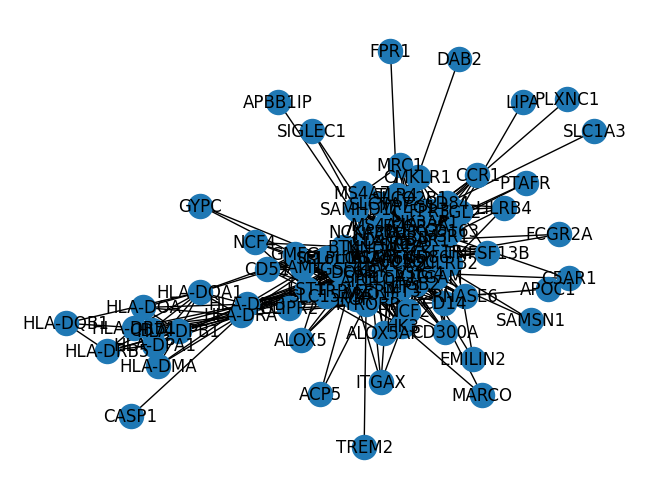

Community 2 has 67 nodes.


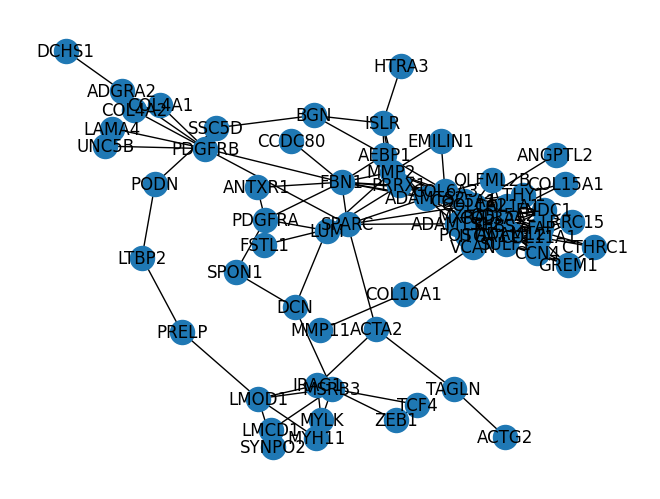

Community 3 has 64 nodes.


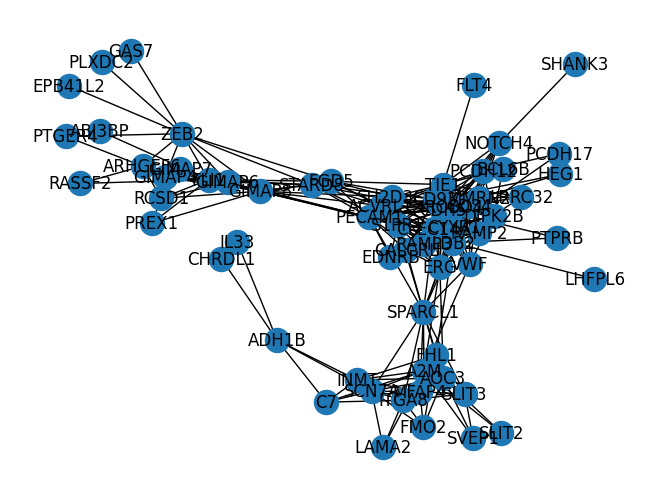

Community 4 has 51 nodes.


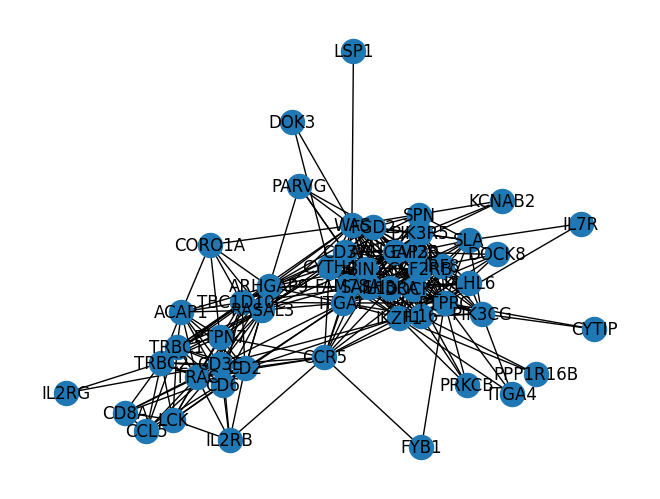

Community 5 has 15 nodes.


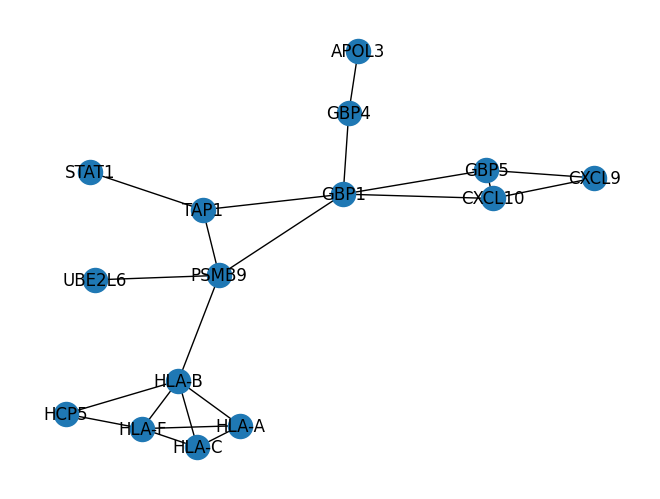

Community 6 has 2 nodes.


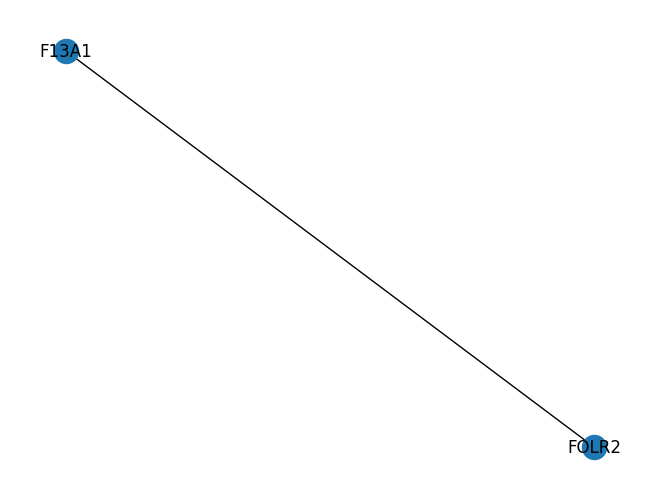

In [14]:
# Create subgraphs for each community
subgraphs = []
for community in communities:
    
    subgraphs.append(G_gxp.subgraph(community))

# Print the number of nodes in each subgraph
# And draw the subgraph
for i, subgraph in enumerate(subgraphs):
    print(f'Community {i+1} has {subgraph.number_of_nodes()} nodes.')
    
    ### YOUR CODE HERE ###
    nx.draw(subgraph, with_labels=True)
    
    plt.show() # Forces the plot to be displayed
    
    

**Visualising the Communities**

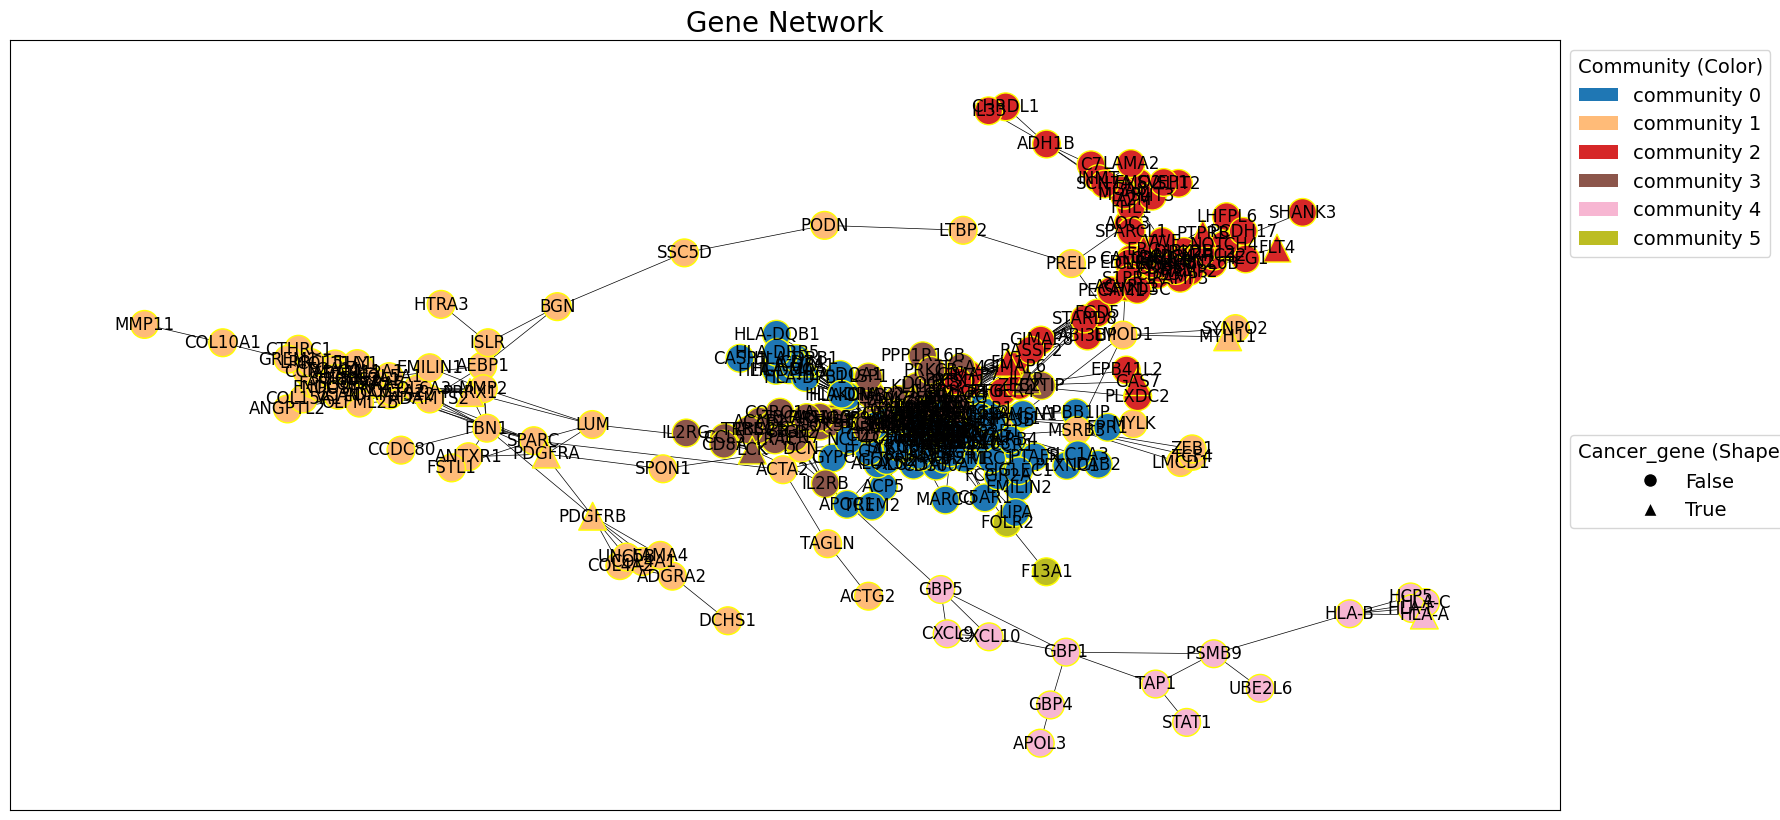

In [15]:
# Visualise the gene correlation network with community memberships

### YOUR CODE HERE ###
draw_network_with_node_attrs(G_gxp, title='Gene Network', node_attributes=node_attributes, communities=communities, color_attr='community', shape_attr='cancer_gene', with_labels=True)

Performing ORA on individual clusters can help in understanding distinct biological significance of each cluster, revealing how certain pathways or functions are associated with specific subsets of genes.

In [16]:
# Function to perform ORA on a given list of genes
def communityORA(genes):
    enr = gp.enrichr(gene_list=genes, gene_sets=[gene_sets], organism='human', outdir=None)
    return enr

# 1. Convert communities to lists for ORA 2. Sort the list of communities by their length in descending order

### YOUR CODE HERE ###
communities = [list(community) for community in communities]
communities = sorted(communities, key=len, reverse=True)

# Perform ORA for three selected communities
community1_enr = communityORA(communities[0])
community2_enr = communityORA(communities[1])
community3_enr = communityORA(communities[2])

# Print the top 10 results for each community
x = PrettyTable()
x.field_names = ["Community 1", "Community 2", "Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i], community2_enr.results['Term'][i], community3_enr.results['Term'][i]])
print(x)


+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|                 Community 1                  |                     Community 2                      |                   Community 3                   |
+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|       Staphylococcus aureus infection        |           Protein digestion and absorption           |             Cell adhesion molecules             |
|                  Phagosome                   |                    Focal adhesion                    |       Complement and coagulation cascades       |
|                Leishmaniasis                 |               ECM-receptor interaction               |             ECM-receptor interaction            |
|                 Tuberculosis                 |              Relaxin signal

### Gene Set Enrichment Analysis (GSEA)

Gene Set Enrichment Analysis (GSEA) is a genome-wide expression analysis method designed to interpret expression profiles focusing on pre-defined gene sets [(Subramanian et al., 2005)](https://doi.org/10.1073/pnas.0506580102). These gene sets are curated based on prior biological knowledge, such as published information about biochemical pathways or patterns of coexpression observed in previous experimental studies. The genes can be ordered in a ranked list, according to their differential expression between the classes. The primary objective of GSEA is to assess whether the genes within a given gene set tend to occur toward the top (or bottom) of the ranked list. This ranking is based on the correlation between gene expression and a particular phenotypic class distinction. By evaluating the distribution of gene set members within the ranked list, GSEA identifies whether the set is correlated with the phenotypic class, thus providing insights into underlying biological mechanisms. This method contrasts with traditional single-gene analysis by focusing on the collective behavior of gene sets, thereby uncovering biologically significant patterns that might be overlooked when examining individual genes in isolation. We use `gseapy` to perform GSEA with the gene set `KEGG_2021_Human`.

<!-- (https://pnnl-comp-mass-spec.github.io/proteomics-data-analysis-tutorial/gsea.html) for referencing.  -->


In [17]:
# Display the first five rows of the dataframe "tcga_gxp_df"
tcga_gxp_df.head(5)

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,TCGA-73-4662,TCGA-44-7671,TCGA-78-8660,TCGA-62-A46P,TCGA-55-6978,TCGA-50-6592,TCGA-38-4625,TCGA-80-5611,TCGA-86-8054,TCGA-55-6986,TCGA-L9-A5IP,TCGA-69-7764,TCGA-49-6744,TCGA-75-5125,TCGA-38-4626,TCGA-69-7763,TCGA-86-8279,TCGA-93-8067,TCGA-97-8179,TCGA-55-A48Y,TCGA-86-8055,TCGA-91-6835,TCGA-55-6982,TCGA-55-A4DF,TCGA-44-6774,TCGA-50-5066,TCGA-05-5423,TCGA-67-3774,TCGA-97-A4M2,TCGA-95-7567,TCGA-49-AAR0,TCGA-44-2656,TCGA-53-7813,TCGA-O1-A52J,TCGA-35-4122,TCGA-55-8092,TCGA-49-6761,TCGA-49-4507,TCGA-55-7816,TCGA-78-7145,TCGA-55-6983,TCGA-53-7624,TCGA-97-A4M3,TCGA-50-5068,TCGA-78-8648,TCGA-44-6778,TCGA-80-5608,TCGA-86-8281,TCGA-MP-A4T6,TCGA-55-8085,TCGA-62-8399,TCGA-97-A4M5,TCGA-97-7547,TCGA-05-5429,TCGA-55-7994,TCGA-55-8094,TCGA-05-4425,TCGA-44-4112,TCGA-49-6767,TCGA-49-4490,TCGA-MP-A4T9,TCGA-50-5942,TCGA-MP-A4SV,TCGA-49-AAR4,TCGA-05-4397,TCGA-44-A47A,TCGA-86-8359,TCGA-78-7539,TCGA-MP-A4T8,TCGA-99-8032,TCGA-50-6595,TCGA-55-6968,TCGA-44-8120,TCGA-55-8302,TCGA-99-8025,TCGA-64-1679,TCGA-95-8039,TCGA-44-A479,TCGA-44-6148,TCGA-NJ-A55O,TCGA-MP-A5C7,TCGA-64-5778,TCGA-55-6971,TCGA-49-AARN,TCGA-44-A47B,TCGA-55-5899,TCGA-49-AAQV,TCGA-99-8028,TCGA-75-6205,TCGA-97-8552,TCGA-50-8459,TCGA-05-5425,TCGA-78-7150,TCGA-86-A4P7,TCGA-49-4512,TCGA-55-8206,TCGA-55-8614,TCGA-64-5815,TCGA-L9-A50W,TCGA-73-4675,TCGA-55-7995,TCGA-05-4433,TCGA-55-7727,TCGA-44-2668,TCGA-44-A4SU,TCGA-55-7907,TCGA-69-7765,TCGA-49-4487,TCGA-44-2662,TCGA-67-6216,TCGA-55-7283,TCGA-86-8280,TCGA-91-6840,TCGA-78-7154,TCGA-49-4488,TCGA-93-7348,TCGA-62-A470,TCGA-78-7147,TCGA-50-5936,TCGA-55-6984,TCGA-50-5941,TCGA-69-7978,TCGA-78-7220,TCGA-55-8616,TCGA-44-A4SS,TCGA-55-7570,TCGA-78-7146,TCGA-44-3398,TCGA-05-5420,TCGA-50-5072,TCGA-05-4396,TCGA-05-4405,TCGA-50-5935,TCGA-38-4629,TCGA-55-8619,TCGA-05-4410,TCGA-73-4676,TCGA-97-8172,TCGA-44-7661,TCGA-05-4384,TCGA-44-2655,TCGA-80-5607,TCGA-67-3770,TCGA-91-6836,TCGA-95-7562,TCGA-55-8511,TCGA-44-6776,TCGA-95-7948,TCGA-91-7771,TCGA-50-5944,TCGA-MN-A4N5,TCGA-73-4677,TCGA-78-7540,TCGA-91-6829,TCGA-78-8640,TCGA-62-8398,TCGA-55-8512,TCGA-83-5908,TCGA-55-6987,TCGA-93-A4JP,TCGA-73-A9RS,TCGA-L4-A4E5,TCGA-86-8074,TCGA-86-8358,TCGA-78-7158,TCGA-91-8497,TCGA-49-AARO,TCGA-78-7159,TCGA-55-7227,TCGA-86-7714,TCGA-L9-A7SV,TCGA-78-7143,TCGA-91-8499,TCGA-49-AAR3,TCGA-55-8620,TCGA-69-8255,TCGA-75-6207,TCGA-62-A46Y,TCGA-NJ-A4YF,TCGA-91-6830,TCGA-62-8395,TCGA-49-4486,TCGA-44-6145,TCGA-86-A4P8,TCGA-78-7537,TCGA-44-3919,TCGA-35-4123,TCGA-62-8394,TCGA-69-7761,TCGA-62-A46U,TCGA-97-8547,TCGA-97-7554,TCGA-50-6673,TCGA-95-7039,TCGA-95-7944,TCGA-55-8301,TCGA-78-7152,TCGA-05-4390,TCGA-44-7659,TCGA-97-7941,TCGA-49-4514,TCGA-55-A490,TCGA-55-8508,TCGA-MP-A4TE,TCGA-97-A4M1,TCGA-75-6206,TCGA-86-8671,TCGA-78-7160,TCGA-64-1681,TCGA-49-4494,TCGA-50-5946,TCGA-55-7913,TCGA-44-6779,TCGA-49-AARE,TCGA-05-4403,TCGA-99-AA5R,TCGA-73-4659,TCGA-50-8457,TCGA-75-5147,TCGA-55-8507,TCGA-78-7536,TCGA-95-A4VK,TCGA-38-4627,TCGA-67-6215,TCGA-69-7973,TCGA-05-5715,TCGA-75-7030,TCGA-44-2666,TCGA-62-A472,TCGA-55-6985,TCGA-J2-A4AG,TCGA-97-A4LX,TCGA-55-6543,TCGA-97-7938,TCGA-35-3615,TCGA-44-2657,TCGA-55-8505,TCGA-97-8175,TCGA-49-4510,TCGA-MP-A4TK,TCGA-50-5044,TCGA-49-AAR2,TCGA-05-4250,TCGA-97-7937,TCGA-64-5774,TCGA-86-8674,TCGA-50-6590,TCGA-64-5779,TCGA-75-5146,TCGA-44-6144,TCGA-78-8662,TCGA-55-7911,TCGA-86-8585,TCGA-38-A44F,TCGA-64-1680,TCGA-97-A4M6,TCGA-75-6214,TCGA-55-6980,TCGA-97-7553,TCGA-55-A48X,TCGA-64-1677,TCGA-73-7498,TCGA-38-6178,TCGA-44-7670,TCGA-62-A471,TCGA-49-4505,TCGA-NJ-A7XG,TCGA-55-6981,TCGA-91-6848,TCGA-55-8090,TCGA-55-7725,TCGA-55-8207,TCGA-44-6146,TCGA-05-4434,TCGA-55-6979,TCGA-05-4427,TCGA-55-8615,TCGA-50-5939,TCGA-05-4418,TCGA-67-6217,TCGA-49-6745,TCGA-55-1595,TCGA-49-6742,TCGA-05-4402,TCGA-05-4382,TCGA-55-7576,TCGA-67-3773,TCGA-78-7633,TCGA-50-6597,TCGA-44-2659,TCGA-95-7947,TCGA-55-7724,TCGA-J2-A4AD,TCGA-55-8091,TCGA-55-1592,TCGA-73-4670,TCGA-55-1594,TCGA-55-

In [18]:
tcga_gxp_meta.head(3)

,patient,race,gender,sample_type,cigarettes_per_day,Smoked,sizeFactor,replaceable
_row,,,,,,,,
TCGA-38-7271,TCGA-38-7271,white,female,Primary Tumor,1.3699,Smoker,0.5841,True
TCGA-55-7914,TCGA-55-7914,white,female,Primary Tumor,0.274,Smoker,0.9873,True
TCGA-95-7043,TCGA-95-7043,white,female,Primary Tumor,2.1918,Smoker,0.5439,True


Assign classes based on phenotypic attributes in metadata (e.g., smoking status)

In [19]:
# Create a dictionary to store the class assignments for each sample
classes = {}

# Iterate through the columns (samples)
for sample in tcga_gxp_df.loc[G_gxp_nodes_list].columns: # ".loc[G_gxp_nodes_list]" grabs rows of specified gene symbols
    
    # Assign class labels based on the smoking status from the metadata
    
    if tcga_gxp_meta.loc[sample, 'Smoked'] == 'Smoker':
        ### YOUR CODE HERE ###
        classes[sample] = 'smoker' 
    elif tcga_gxp_meta.loc[sample, 'Smoked'] == 'Never':
        ### YOUR CODE HERE ###
        classes[sample] = 'control'
    else:
        pass


In [20]:
classes

{'TCGA-38-7271': 'smoker',
 'TCGA-55-7914': 'smoker',
 'TCGA-95-7043': 'smoker',
 'TCGA-73-4658': 'smoker',
 'TCGA-86-8076': 'control',
 'TCGA-55-7726': 'smoker',
 'TCGA-44-6147': 'control',
 'TCGA-50-5932': 'control',
 'TCGA-44-2661': 'control',
 'TCGA-86-7954': 'smoker',
 'TCGA-73-4662': 'smoker',
 'TCGA-44-7671': 'control',
 'TCGA-78-8660': 'smoker',
 'TCGA-62-A46P': 'smoker',
 'TCGA-55-6978': 'control',
 'TCGA-50-6592': 'control',
 'TCGA-38-4625': 'smoker',
 'TCGA-80-5611': 'smoker',
 'TCGA-86-8054': 'smoker',
 'TCGA-55-6986': 'control',
 'TCGA-L9-A5IP': 'control',
 'TCGA-69-7764': 'smoker',
 'TCGA-49-6744': 'smoker',
 'TCGA-75-5125': 'smoker',
 'TCGA-38-4626': 'smoker',
 'TCGA-69-7763': 'smoker',
 'TCGA-86-8279': 'control',
 'TCGA-93-8067': 'smoker',
 'TCGA-97-8179': 'smoker',
 'TCGA-55-A48Y': 'smoker',
 'TCGA-86-8055': 'smoker',
 'TCGA-91-6835': 'smoker',
 'TCGA-55-6982': 'control',
 'TCGA-55-A4DF': 'smoker',
 'TCGA-44-6774': 'smoker',
 'TCGA-50-5066': 'control',
 'TCGA-05-5423':

In [21]:
tcga_gxp_df.loc[G_gxp_nodes_list].head(2)

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,TCGA-73-4662,TCGA-44-7671,TCGA-78-8660,TCGA-62-A46P,TCGA-55-6978,TCGA-50-6592,TCGA-38-4625,TCGA-80-5611,TCGA-86-8054,TCGA-55-6986,TCGA-L9-A5IP,TCGA-69-7764,TCGA-49-6744,TCGA-75-5125,TCGA-38-4626,TCGA-69-7763,TCGA-86-8279,TCGA-93-8067,TCGA-97-8179,TCGA-55-A48Y,TCGA-86-8055,TCGA-91-6835,TCGA-55-6982,TCGA-55-A4DF,TCGA-44-6774,TCGA-50-5066,TCGA-05-5423,TCGA-67-3774,TCGA-97-A4M2,TCGA-95-7567,TCGA-49-AAR0,TCGA-44-2656,TCGA-53-7813,TCGA-O1-A52J,TCGA-35-4122,TCGA-55-8092,TCGA-49-6761,TCGA-49-4507,TCGA-55-7816,TCGA-78-7145,TCGA-55-6983,TCGA-53-7624,TCGA-97-A4M3,TCGA-50-5068,TCGA-78-8648,TCGA-44-6778,TCGA-80-5608,TCGA-86-8281,TCGA-MP-A4T6,TCGA-55-8085,TCGA-62-8399,TCGA-97-A4M5,TCGA-97-7547,TCGA-05-5429,TCGA-55-7994,TCGA-55-8094,TCGA-05-4425,TCGA-44-4112,TCGA-49-6767,TCGA-49-4490,TCGA-MP-A4T9,TCGA-50-5942,TCGA-MP-A4SV,TCGA-49-AAR4,TCGA-05-4397,TCGA-44-A47A,TCGA-86-8359,TCGA-78-7539,TCGA-MP-A4T8,TCGA-99-8032,TCGA-50-6595,TCGA-55-6968,TCGA-44-8120,TCGA-55-8302,TCGA-99-8025,TCGA-64-1679,TCGA-95-8039,TCGA-44-A479,TCGA-44-6148,TCGA-NJ-A55O,TCGA-MP-A5C7,TCGA-64-5778,TCGA-55-6971,TCGA-49-AARN,TCGA-44-A47B,TCGA-55-5899,TCGA-49-AAQV,TCGA-99-8028,TCGA-75-6205,TCGA-97-8552,TCGA-50-8459,TCGA-05-5425,TCGA-78-7150,TCGA-86-A4P7,TCGA-49-4512,TCGA-55-8206,TCGA-55-8614,TCGA-64-5815,TCGA-L9-A50W,TCGA-73-4675,TCGA-55-7995,TCGA-05-4433,TCGA-55-7727,TCGA-44-2668,TCGA-44-A4SU,TCGA-55-7907,TCGA-69-7765,TCGA-49-4487,TCGA-44-2662,TCGA-67-6216,TCGA-55-7283,TCGA-86-8280,TCGA-91-6840,TCGA-78-7154,TCGA-49-4488,TCGA-93-7348,TCGA-62-A470,TCGA-78-7147,TCGA-50-5936,TCGA-55-6984,TCGA-50-5941,TCGA-69-7978,TCGA-78-7220,TCGA-55-8616,TCGA-44-A4SS,TCGA-55-7570,TCGA-78-7146,TCGA-44-3398,TCGA-05-5420,TCGA-50-5072,TCGA-05-4396,TCGA-05-4405,TCGA-50-5935,TCGA-38-4629,TCGA-55-8619,TCGA-05-4410,TCGA-73-4676,TCGA-97-8172,TCGA-44-7661,TCGA-05-4384,TCGA-44-2655,TCGA-80-5607,TCGA-67-3770,TCGA-91-6836,TCGA-95-7562,TCGA-55-8511,TCGA-44-6776,TCGA-95-7948,TCGA-91-7771,TCGA-50-5944,TCGA-MN-A4N5,TCGA-73-4677,TCGA-78-7540,TCGA-91-6829,TCGA-78-8640,TCGA-62-8398,TCGA-55-8512,TCGA-83-5908,TCGA-55-6987,TCGA-93-A4JP,TCGA-73-A9RS,TCGA-L4-A4E5,TCGA-86-8074,TCGA-86-8358,TCGA-78-7158,TCGA-91-8497,TCGA-49-AARO,TCGA-78-7159,TCGA-55-7227,TCGA-86-7714,TCGA-L9-A7SV,TCGA-78-7143,TCGA-91-8499,TCGA-49-AAR3,TCGA-55-8620,TCGA-69-8255,TCGA-75-6207,TCGA-62-A46Y,TCGA-NJ-A4YF,TCGA-91-6830,TCGA-62-8395,TCGA-49-4486,TCGA-44-6145,TCGA-86-A4P8,TCGA-78-7537,TCGA-44-3919,TCGA-35-4123,TCGA-62-8394,TCGA-69-7761,TCGA-62-A46U,TCGA-97-8547,TCGA-97-7554,TCGA-50-6673,TCGA-95-7039,TCGA-95-7944,TCGA-55-8301,TCGA-78-7152,TCGA-05-4390,TCGA-44-7659,TCGA-97-7941,TCGA-49-4514,TCGA-55-A490,TCGA-55-8508,TCGA-MP-A4TE,TCGA-97-A4M1,TCGA-75-6206,TCGA-86-8671,TCGA-78-7160,TCGA-64-1681,TCGA-49-4494,TCGA-50-5946,TCGA-55-7913,TCGA-44-6779,TCGA-49-AARE,TCGA-05-4403,TCGA-99-AA5R,TCGA-73-4659,TCGA-50-8457,TCGA-75-5147,TCGA-55-8507,TCGA-78-7536,TCGA-95-A4VK,TCGA-38-4627,TCGA-67-6215,TCGA-69-7973,TCGA-05-5715,TCGA-75-7030,TCGA-44-2666,TCGA-62-A472,TCGA-55-6985,TCGA-J2-A4AG,TCGA-97-A4LX,TCGA-55-6543,TCGA-97-7938,TCGA-35-3615,TCGA-44-2657,TCGA-55-8505,TCGA-97-8175,TCGA-49-4510,TCGA-MP-A4TK,TCGA-50-5044,TCGA-49-AAR2,TCGA-05-4250,TCGA-97-7937,TCGA-64-5774,TCGA-86-8674,TCGA-50-6590,TCGA-64-5779,TCGA-75-5146,TCGA-44-6144,TCGA-78-8662,TCGA-55-7911,TCGA-86-8585,TCGA-38-A44F,TCGA-64-1680,TCGA-97-A4M6,TCGA-75-6214,TCGA-55-6980,TCGA-97-7553,TCGA-55-A48X,TCGA-64-1677,TCGA-73-7498,TCGA-38-6178,TCGA-44-7670,TCGA-62-A471,TCGA-49-4505,TCGA-NJ-A7XG,TCGA-55-6981,TCGA-91-6848,TCGA-55-8090,TCGA-55-7725,TCGA-55-8207,TCGA-44-6146,TCGA-05-4434,TCGA-55-6979,TCGA-05-4427,TCGA-55-8615,TCGA-50-5939,TCGA-05-4418,TCGA-67-6217,TCGA-49-6745,TCGA-55-1595,TCGA-49-6742,TCGA-05-4402,TCGA-05-4382,TCGA-55-7576,TCGA-67-3773,TCGA-78-7633,TCGA-50-6597,TCGA-44-2659,TCGA-95-7947,TCGA-55-7724,TCGA-J2-A4AD,TCGA-55-8091,TCGA-55-1592,TCGA-73-4670,TCGA-55-1594,TCGA-55-

In [22]:
# Perform GSEA using the prepared data and class assignments
gs_res = gp.gsea(data=tcga_gxp_df.loc[G_gxp_nodes_list], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7)

# Display the top results from the GSEA

### YOUR CODE HERE ###
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Toxoplasmosis,0.672196,1.87385,0.017544,0.131839,0.05,11/19,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA
1,gsea,Influenza A,0.708245,1.7236,0.117647,0.477917,0.11,11/17,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
2,gsea,Th1 and Th2 cell differentiation,0.735164,1.659187,0.096154,0.399637,0.18,10/16,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
3,gsea,Th17 cell differentiation,0.735164,1.659187,0.096154,0.399637,0.18,10/16,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
4,gsea,Human T-cell leukemia virus 1 infection,0.645243,1.649653,0.083333,0.323006,0.18,13/22,18.67%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F


#### Visualising GSEA Results

Once you have performed GSEA, the next step is to visualise the results. Visualisation helps in interpreting the biological roles of the enriched gene sets. Here, we visualise GSEA results with Barcode Enrichment Plot, Heatmap, Clustermap, and Dot Plot. 

**Barcode Enrichment Plot**

Barcode Enrichment Plot shows the positions of members of a given gene set in a ranked list of enrichment scores for the top enriched terms. The scores are ranked left to right from smallest to largest. The ranked scores are represented by a shaded bar, forming a pattern like a barcode. 

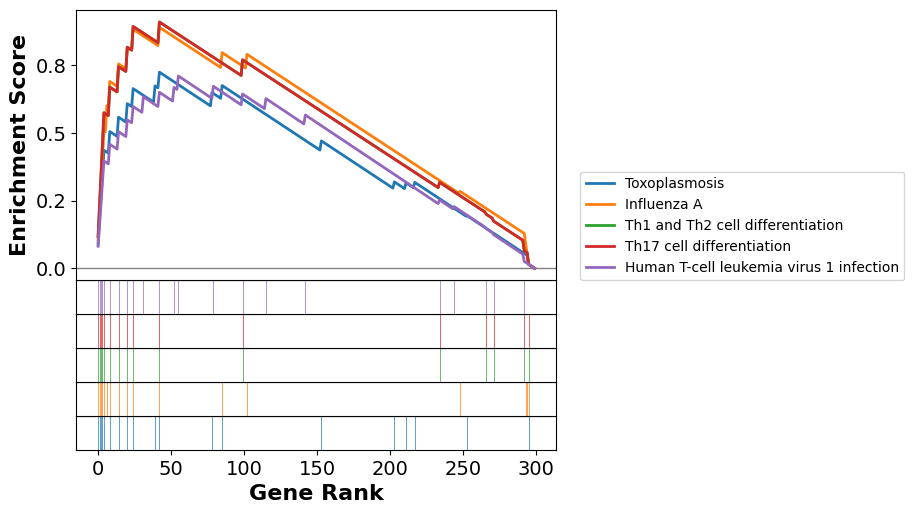

In [23]:
# Extract the enriched terms from the GSEA results. The terms represent pathways or functional categories that are significantly enriched in the dataset.

### YOUR CODE HERE ###
terms = gs_res.res2d.Term

# Plot the top 5 enriched terms
# The plot function visualizes the enrichment results
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})

You can view and extract leading-edge genes from GSEA results. Leading-edge genes are the subset of genes that contribute most to the enrichment score.

In [24]:
# View leading-edge genes from the GSEA results. 
gs_res.res2d[['Term', 'Lead_genes']].head(10)

,Term,Lead_genes
0,Toxoplasmosis,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA
1,Influenza A,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
2,Th1 and Th2 cell differentiation,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
3,Th17 cell differentiation,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
4,Human T-cell leukemia virus 1 infection,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F
5,Leishmaniasis,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA;ITGB2
6,Phagosome,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;MSR1;HLA-DOA;MARCO;ITGB2;HLA-F;MRC1;HLA-B;ITGAM;TLR4
7,Viral myocarditis,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA;ITGB2;HLA-F;LAMA2;HLA-B;CD86
8,Rheumatoid arthritis,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA;ITGB2;ACP5;TLR4;CD86
9,Epstein-Barr virus infection,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;BTK;HLA-DRB5;HLA-DOA;HLA-F


**Heatmap Visualisation**

`gseapy` provides a heatmap function to visualise the expression levels of the leading-edge genes. The heatmap provides a visual representation of how these genes are expressed across different samples in relation to their assigned phenotypic classes. 

In [25]:
# Import the heatmap function from gseapy
from gseapy import heatmap

# Select the index of the term to visualize
i = 0

# Extract the genes contributing to the enrichment of the selected term

### YOUR CODE HERE ###
genes = gs_res.res2d.Lead_genes[i].split(";")
print(genes)

['HLA-DRB1', 'HLA-DMA', 'HLA-DPB1', 'HLA-DRA', 'HLA-DMB', 'HLA-DPA1', 'HLA-DQB1', 'HLA-DQA1', 'HLA-DRB5', 'ALOX5', 'HLA-DOA']


[]

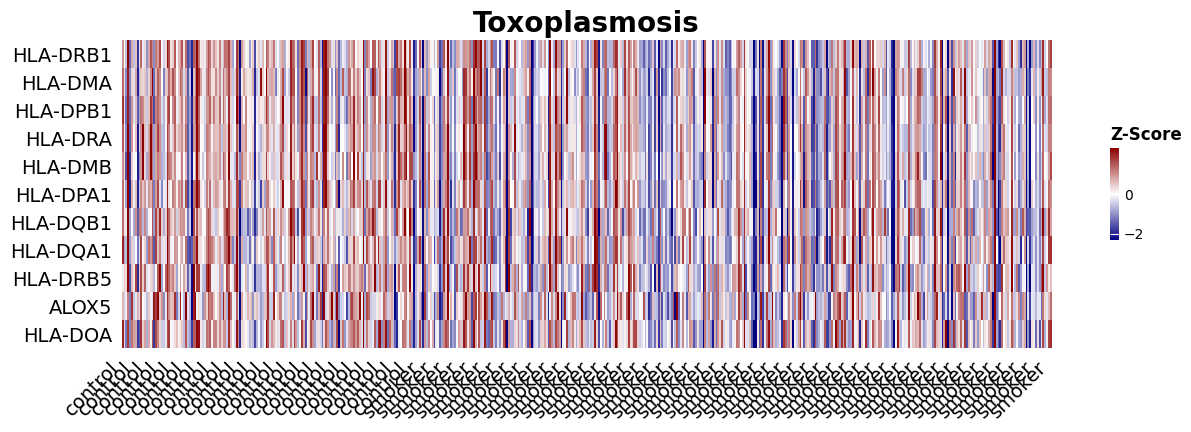

In [26]:
# Generate a heatmap of the expression levels of the leading-edge genes
ax = heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(15, 4))

# Update the x-tick labels with the class labels
xtick_labels = [classes[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.plot()

**Clustermap Visualisation**

The function `clustermap` from `seaborn` is used to create a clustered heatmap. It not only shows the expression levels of the leading-edge genes but also clusters them based on similarity, providing additional insights into gene expression patterns. The cluster map includes dendrograms, which show the hierarchical clustering of both genes and samples, helping to identify groups of co-expressed genes and similar samples.

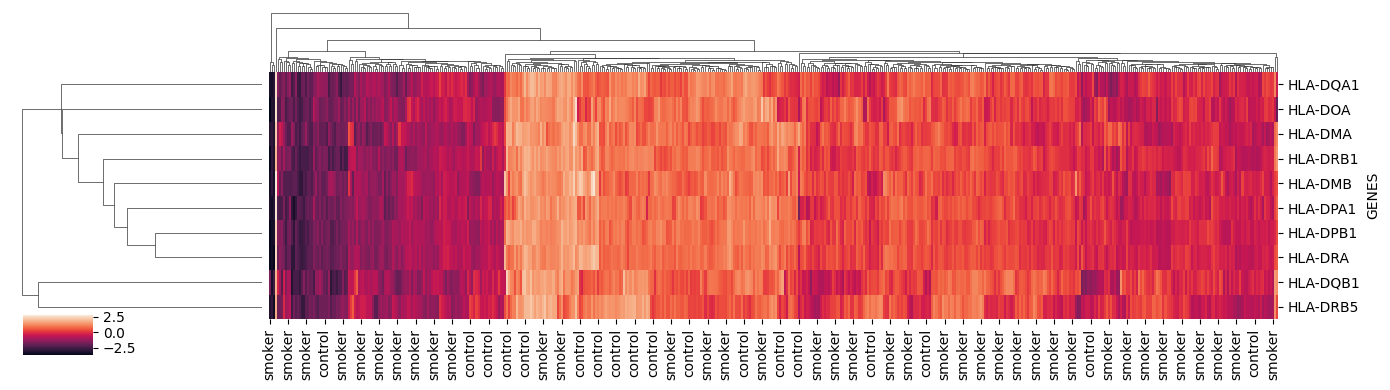

In [27]:

# Import the clustermap function from seaborn
from seaborn import clustermap

# Select the index of the term to visualize
i = 2

# Extract the genes contributing to the enrichment of the selected term
genes = gs_res.res2d.Lead_genes[i].split(";")

# Extract the relevant subset of the heatmap data

### YOUR CODE HERE ###
data = gs_res.heatmat.loc[genes]

# Rename the columns based on the class assignments
data.rename(columns=classes, inplace=True)

# Generate a cluster map of the expression levels of the leading-edge genes
ax = clustermap(
    data=data,  # The data to cluster
    method='average',  # Clustering method
    metric='euclidean',  # Distance metric
    z_score=0,  # Standardize the data along the rows
    figsize=(14, 4),  # Size of the figure
    dendrogram_ratio=0.2,  # Ratio of the dendrogram
    colors_ratio=0.03,  # Ratio of the colors
    cbar_pos=(0.02, 0.1, 0.05, 0.1)  # Position of the color bar
)

**Dot Plot Visualisation**

Use the `dotplot` function in `gseapy` to create a visual representation of the GSEA results. Here we use "FDR q-val" to determine the dot sizes, which represents the false discovery rate adjusted p-values. We display normalised enrichment score (NES) value as the x-axis. 

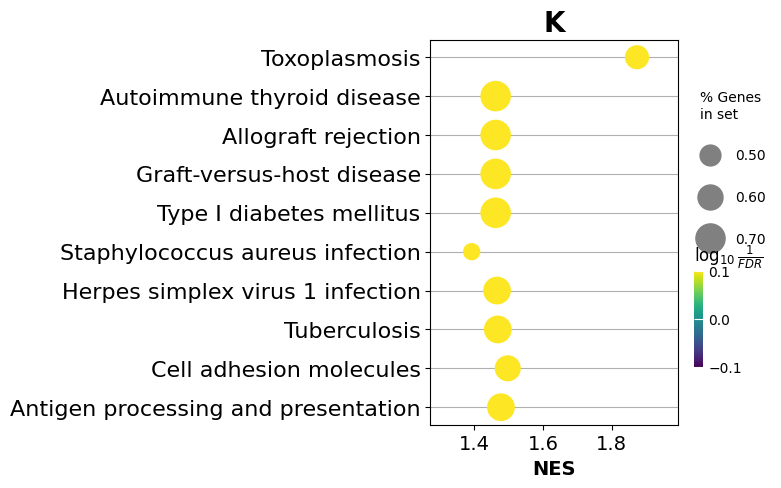

In [28]:
# Import the dotplot function from gseapy
from gseapy import dotplot

# Generate the dot plot for the GSEA results
# The dotplot function visualizes the enrichment results, focusing on the FDR q-values
ax = dotplot(gs_res.res2d,
             column="FDR q-val",  # Column to be used for dot size
             title=gene_sets[0],  # Title the plot as the chosen gene set name 
             cmap=plt.cm.viridis,  # Color map for the dots
             size=5,  # Size of the dots
             figsize=(4, 5),  # Size of the figure
             cutoff=1)  # Cutoff for displaying the terms

#### GSEA on Clusters

Similarly to ORA, GSEA can also be performed on individual communities after clustering. This allows for a more granular analysis, revealing pathways and functions that are enriched within particular subgroups of the data.


In [29]:
# Define a function to perform GSEA on a given list of genes (community)
def communityGSEA(genes, gene_sets='KEGG_2021_Human', classes=classes):
    gs_res = gp.gsea(data=tcga_gxp_df.loc[genes], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7, min_size=1) 
    return gs_res

# Perform GSEA for three community

### YOUR CODE HERE ###
community1_gsea = communityGSEA(communities[0])
community2_gsea = communityGSEA(communities[1]) 
community3_gsea = communityGSEA(communities[2])


In [30]:
# Display the top results for the first community

### YOUR CODE HERE ###
community1_gsea.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Epstein-Barr virus infection,0.853817,1.789511,0.0,0.324881,0.14,10/11,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;BTK;HLA-DRB5
1,gsea,Leishmaniasis,0.667361,1.767749,0.040816,0.181183,0.17,11/18,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5
2,gsea,Influenza A,0.805713,1.723862,0.0,0.191596,0.2,10/12,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5
3,gsea,Phagosome,0.595196,1.717777,0.041667,0.149945,0.21,16/22,34.65%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;MSR1;HLA-DOA;MARCO;ITGB2;MRC1
4,gsea,Cell adhesion molecules,0.649813,1.710744,0.04,0.127453,0.22,10/16,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;SELPLG;HLA-DQA1;HLA-DRB5


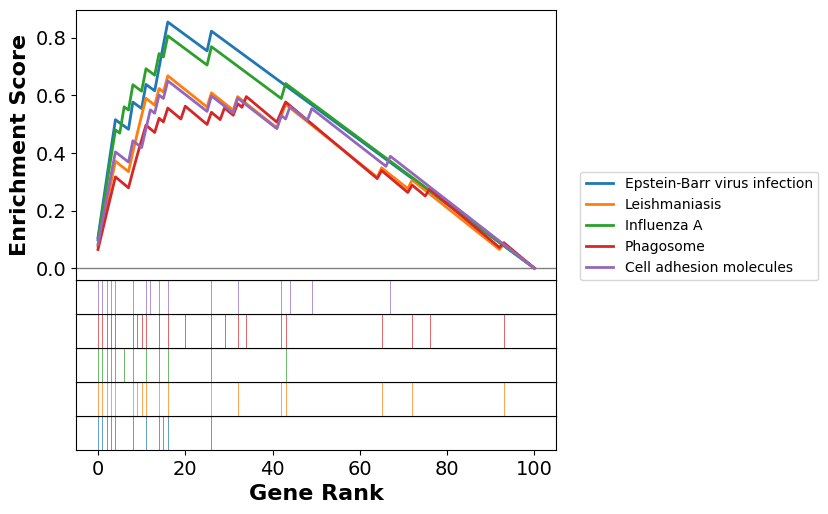

In [31]:
# Extract the enriched terms from the GSEA results for the first community
terms = community1_gsea.res2d.Term

# Plot the top 5 enriched terms for the first community
axs = community1_gsea.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})